## Подготовка

In [191]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с разряженными матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from catboost import CatBoostClassifier, CatBoost, Pool

# Визуализация
import matplotlib.pyplot as plt

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from metrics import precision_at_k, recall_at_k
from utils import prefilter_items
from recommenders import MainRecommender

In [151]:
ITEM_COL = 'item_id'
USER_COL = 'user_id'
VAL_MATCHER_WEEKS = 6
VAL_RANKER_WEEKS = 3

__Open dataset__

In [152]:
data = pd.read_csv('data/retail_train.csv')
item_features = pd.read_csv('data/product.csv')
user_features = pd.read_csv('data/hh_demographic.csv')

In [153]:
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': ITEM_COL}, inplace=True)
user_features.rename(columns={'household_key': USER_COL }, inplace=True)

__Train test split__

In [154]:
# Данные для тренировки и валидации matching модели
data_train_matcher = data[data['week_no'] < data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)]

data_val_matcher = data[(data['week_no'] >= data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)) &
                      (data['week_no'] < data['week_no'].max() - (VAL_RANKER_WEEKS))]


# Данные для тренировки ranking модели
data_train_ranker = data_val_matcher.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться

# Данные для теста ranking, matching модели
data_val_ranker = data[data['week_no'] >= data['week_no'].max() - VAL_RANKER_WEEKS]

__Prefilter items__

In [155]:
n_items_before = data_train_matcher['item_id'].nunique()

data_train_matcher = prefilter_items(data_train_matcher, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_matcher['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


/Users/blaze/Documents/Notebooks/recsys/recsys-homework/utils.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['price'] = data['sales_value'] / (np.maximum(data['quantity'], 1))


__Warm start__

In [156]:
# ищем общих пользователей
common_users = data_train_matcher.user_id.values

data_val_matcher = data_val_matcher[data_val_matcher.user_id.isin(common_users)]
data_train_ranker = data_train_ranker[data_train_ranker.user_id.isin(common_users)]
data_val_ranker = data_val_ranker[data_val_ranker.user_id.isin(common_users)]

__Init main recommender__

In [157]:
recommender = MainRecommender(data_train_matcher)

100%|██████████| 5001/5001 [00:00<00:00, 18806.04it/s]


__Eval recall of matching__

In [158]:
ACTUAL_COL = 'actual'

In [159]:
result_eval_matcher = data_val_matcher.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_matcher.columns=[USER_COL, ACTUAL_COL]
result_eval_matcher.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [160]:
def eval_recall(df_result, recommend_model, N):
    result_col_name = 'result'
    target_col_name = USER_COL
    df_result[result_col_name] = df_result[target_col_name].apply(lambda x: recommend_model(x, N=N))
    return df_result.apply(lambda row: recall_at_k(row[result_col_name], row[ACTUAL_COL], k=N), axis=1).mean()

## Задание 1

A)

In [161]:
# Купленные товары
eval_recall(result_eval_matcher, recommender.get_own_recommendations, N=50)

0.06525657038145165

In [166]:
# Похожие пользователи
eval_recall(result_eval_matcher, recommender.get_similar_users_recommendation, N=50)

0.007774424113423559

Пока что я вижу, что рекомендация по похожим пользователям гораздо прожорливей и чуть менее эффективна по метрике recall@k, чем рекомендация топ купленных товаров

B)

In [167]:
K = [20, 50, 100, 200, 500]

In [168]:
recalls = []
for k in K:
    recalls.append(eval_recall(result_eval_matcher, recommender.get_own_recommendations, N=k))

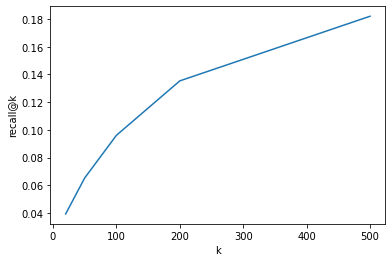

In [169]:
plt.plot(K, recalls)
plt.xlabel('k')
plt.ylabel('recall@k')
plt.show()

C)

Я считаю, что наиболее разумное k является 200, потому что по графику видно, что большее значение k не дает такое сильное увеличение метрики качества

## Подготовка к заданию 2

__Generate train data__

In [37]:
N_PREDICT = 200

In [38]:
df_match_candidates = pd.DataFrame(data_train_ranker[USER_COL].unique())
df_match_candidates.columns = [USER_COL]

In [39]:
df_match_candidates['candidates'] = \
    df_match_candidates[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

In [40]:
df_match_candidates.head(2)

,user_id,candidates
0,2070,"[1105426, 1097350, 879194, 948640, 928263, 944..."
1,2021,"[950935, 1119454, 835578, 863762, 1019142, 102..."


In [41]:
df_items = df_match_candidates.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
df_items.name = 'item_id'
df_items.head(3)

0    1105426
0    1097350
0     879194
Name: item_id, dtype: int64

In [42]:
df_match_candidates = df_match_candidates.drop('candidates', axis=1).join(df_items)
df_match_candidates.head(2)

,user_id,item_id
0,2070,1105426
0,2070,1097350


In [331]:
df_ranker_train = data_train_ranker[[USER_COL, ITEM_COL]].copy()
df_ranker_train['target'] = 1 # То есть куплено
df_ranker_train.head(3)

,user_id,item_id,target
2104867,2070,1019940,1
2107468,2021,840361,1
2107469,2021,856060,1


In [332]:
# Добавяем не купленные товары (target = 0)
df_ranker_train = df_match_candidates.merge(df_ranker_train, on=[USER_COL, ITEM_COL], how='left')

# Чистим дубликаты
df_ranker_train = df_ranker_train.drop_duplicates(subset=[USER_COL, ITEM_COL])

# Заполняем пропуски
df_ranker_train['target'].fillna(0, inplace= True)

In [333]:
df_ranker_train.target.value_counts()

0.0    397661
1.0     17984
Name: target, dtype: int64

In [334]:
df_ranker_train.head(3)

,user_id,item_id,target
0,2070,1105426,0.0
1,2070,1097350,0.0
2,2070,879194,0.0


## Задание 2

### Feature engineering

#### User features

In [59]:
new_user_features = user_features.copy()
new_user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


__Average bill (Средний чек)__

In [69]:
data.head(1)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0


In [70]:
avb_data = data[['user_id', 'basket_id', 'sales_value']].copy()
avb_data.head(5)

,user_id,basket_id,sales_value
0,2375,26984851472,1.39
1,2375,26984851472,0.82
2,2375,26984851472,0.99
3,2375,26984851472,1.21
4,2375,26984851472,1.50


In [74]:
average_bill = avb_data.groupby('basket_id').agg('mean').groupby('user_id').agg('mean')
average_bill

,sales_value
user_id,
1.0,2.726818
2.0,3.281768
3.0,3.268026
4.0,4.044173
5.0,4.368017
...,...
2496.0,7.811230
2497.0,3.981373
2498.0,3.855324


In [76]:
new_user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


In [94]:
average_bill_user_features = average_bill.loc[new_user_features['user_id'], 'sales_value']
average_bill_user_features.head(5)

user_id
1      2.726818
7      2.989986
8      4.734543
13    19.434575
16     4.401541
Name: sales_value, dtype: float64

In [97]:
new_user_features.shape, average_bill_user_features.shape

((801, 9), (801,))

In [100]:
new_user_features['average_bill'] = average_bill_user_features.to_numpy()
new_user_features.head(5)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id,average_bill
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1,2.726818
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7,2.989986
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8,4.734543
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13,19.434575
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16,4.401541


__Billing rate n/month (Количество покупок в месяц)__

In [102]:
data.head(5)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


In [107]:
br_data = data.copy()
br_data['count'] = 1
br_data_basket_id_mean = br_data.groupby('basket_id').agg('mean')
br_data_basket_id_mean.head(5)

,user_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,count
basket_id,,,,,,,,,,,,
26984851472,2375.0,1.0,2.463398e+06,1.000000,1.182000,364.0,-0.258000,1631.0,1.0,0.0,0.0,1.0
26984851516,2375.0,1.0,3.328273e+06,1.166667,2.071667,364.0,-0.543333,1642.0,1.0,0.0,0.0,1.0
26984896261,1364.0,1.0,9.160190e+05,1.000000,2.274000,31742.0,-0.436000,1520.0,1.0,0.0,0.0,1.0
26984905972,1130.0,1.0,9.686606e+05,1.800000,0.510000,31642.0,-0.416000,1340.0,1.0,0.0,0.0,1.0
26984945254,1173.0,1.0,9.599073e+05,1.333333,1.176667,412.0,0.000000,2042.0,1.0,0.0,0.0,1.0


In [113]:
user_num_baskets = br_data_basket_id_mean[['user_id', 'count']].groupby('user_id').agg('count')
user_num_baskets

,count
user_id,
1.0,79
2.0,44
3.0,45
4.0,30
5.0,38
...,...
2496.0,60
2497.0,215
2498.0,158


In [116]:
num_days = data['day'].max()
num_days

663

In [117]:
days_per_month = 30
num_months = num_days / days_per_month
num_months

22.1

In [118]:
user_billings_per_month = user_num_baskets / num_months
user_billings_per_month

,count
user_id,
1.0,3.574661
2.0,1.990950
3.0,2.036199
4.0,1.357466
5.0,1.719457
...,...
2496.0,2.714932
2497.0,9.728507
2498.0,7.149321


In [121]:
new_user_features.head(5)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id,average_bill
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1,2.726818
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7,2.989986
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8,4.734543
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13,19.434575
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16,4.401541


In [125]:
billings_per_month = user_billings_per_month.loc[new_user_features['user_id']]
billings_per_month

,count
user_id,
1,3.574661
7,2.307692
8,4.705882
13,11.447964
16,4.343891
...,...
2494,1.357466
2496,2.714932
2497,9.728507


In [126]:
new_user_features['billings_per_month'] = billings_per_month.to_numpy()
new_user_features.head(5)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id,average_bill,billings_per_month
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1,2.726818,3.574661
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7,2.989986,2.307692
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8,4.734543,4.705882
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13,19.434575,11.447964
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16,4.401541,4.343891


#### Item features

In [127]:
new_item_features = item_features.copy()
new_item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


__Purchases per week (Количество покупок в неделю)__

In [129]:
ppw_data = data.copy()
ppw_data['count'] = 1
ppw_data.head(5)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,count
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0,1
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0,1
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0,1
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0,1
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0,1


In [133]:
item_num_purchases = ppw_data[['item_id', 'count']].groupby('item_id') \
    .agg('count').sort_values('count', ascending=False)
item_num_purchases

,count
item_id,
1082185,27362
6534178,18364
1029743,13455
995242,11397
1106523,9175
...,...
7442882,1
7442885,1
7442888,1


In [134]:
days_per_week = 7
num_weeks = num_days / days_per_week
num_weeks

94.71428571428571

In [135]:
item_purchases_per_week = item_num_purchases / num_weeks
item_purchases_per_week

,count
item_id,
1082185,288.889894
6534178,193.888386
1029743,142.058824
995242,120.330317
1106523,96.870287
...,...
7442882,0.010558
7442885,0.010558
7442888,0.010558


In [139]:
item_features['item_id']

0           25671
1           26081
2           26093
3           26190
4           26355
           ...   
92348    18293142
92349    18293439
92350    18293696
92351    18294080
92352    18316298
Name: item_id, Length: 92353, dtype: int64

In [141]:
item_purchases_per_week.shape

(89051, 1)

In [165]:
item_purchases_per_week = item_purchases_per_week.reindex(item_features['item_id']).fillna(0)
item_purchases_per_week.head(3)

,count
item_id,
25671,0.031674
26081,0.010558
26093,0.010558


In [163]:
item_features_purchases_per_week = item_purchases_per_week.loc[item_features['item_id']]
item_features_purchases_per_week.head(3)

,count
item_id,
25671,0.031674
26081,0.010558
26093,0.010558


In [164]:
new_item_features['purchases_per_week'] = item_features_purchases_per_week.to_numpy()
new_item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,purchases_per_week
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB,0.031674
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,,0.010558


__Price (Цена)__

In [170]:
data.columns

Index(['user_id', 'basket_id', 'day', 'item_id', 'quantity', 'sales_value',
       'store_id', 'retail_disc', 'trans_time', 'week_no', 'coupon_disc',
       'coupon_match_disc'],
      dtype='object')

In [173]:
item_prices = data.groupby('item_id').agg('mean')['sales_value']
item_prices

item_id
25671        6.980000
26081        0.990000
26093        1.590000
26190        1.540000
26355        1.980000
              ...    
17991689     2.490000
17991691     2.490000
18000012     6.653333
18024155     3.990000
18024556    10.170000
Name: sales_value, Length: 89051, dtype: float64

In [176]:
item_features_prices = item_prices.reindex(item_features['item_id']) \
    .fillna(0).loc[item_features['item_id']]
item_features_prices

item_id
25671       6.98
26081       0.99
26093       1.59
26190       1.54
26355       1.98
            ... 
18293142    0.00
18293439    0.00
18293696    0.00
18294080    0.00
18316298    0.00
Name: sales_value, Length: 92353, dtype: float64

In [177]:
new_item_features['price'] = item_features_prices.to_numpy()
new_item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,purchases_per_week,price
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB,0.031674,6.98
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,,0.010558,0.99


__Category mean price (Средняя цена в категории)__

In [183]:
cat_prices = new_item_features[['department', 'price']].groupby('department').agg('mean')['price']
cat_prices

department
                    0.000000
AUTOMOTIVE          3.999914
CHARITABLE CONT     3.870000
CHEF SHOPPE         2.141727
CNTRL/STORE SUP     7.810417
COSMETICS           4.645383
COUP/STR & MFG      1.860702
DAIRY DELI          2.691134
DELI                4.952708
DELI/SNACK BAR      1.616667
DRUG GM             5.132067
ELECT &PLUMBING     1.000000
FLORAL              7.775477
FROZEN GROCERY      2.225306
GARDEN CENTER      10.183636
GM MERCH EXP        3.585167
GRO BAKERY          1.090000
GROCERY             3.100011
HBC                 2.355000
HOUSEWARES          2.990000
KIOSK-GAS          26.108831
MEAT                7.175885
MEAT-PCKGD          3.518354
MEAT-WHSE           1.166667
MISC SALES TRAN    27.343065
MISC. TRANS.        5.406188
NUTRITION           3.192255
PASTRY              4.178275
PHARMACY SUPPLY     2.820000
PHOTO               2.443909
PORK                7.850000
POSTAL CENTER       0.470000
PROD-WHS SALES      2.920000
PRODUCE             2.598643
RES

In [185]:
item_features_cat_prices = cat_prices.loc[item_features['department']]
item_features_cat_prices

department
GROCERY         3.100011
MISC. TRANS.    5.406188
PASTRY          4.178275
GROCERY         3.100011
GROCERY         3.100011
                  ...   
DRUG GM         5.132067
DRUG GM         5.132067
DRUG GM         5.132067
DRUG GM         5.132067
GROCERY         3.100011
Name: price, Length: 92353, dtype: float64

In [186]:
new_item_features['category_mean_price'] = item_features_cat_prices.to_numpy()
new_item_features.head(3)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,purchases_per_week,price,category_mean_price
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB,0.031674,6.98,3.100011
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,,0.010558,0.99,5.406188
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,,0.010558,1.59,4.178275


#### Merge features

In [335]:
df_ranker_train = df_ranker_train.merge(new_item_features, on='item_id', how='left', suffixes=('_x', '_y'))
df_ranker_train = df_ranker_train.merge(new_user_features, on='user_id', how='left', suffixes=('_x', '_y'))
df_ranker_train.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,purchases_per_week,...,category_mean_price,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,average_bill,billings_per_month
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,1.087481,...,4.952708,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.413486,24.434389
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,0.538462,...,3.100011,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.413486,24.434389


In [336]:
df_ranker_train[cat_feats] = df_ranker_train[cat_feats].fillna('Unspecified')
df_ranker_train['average_bill'] = df_ranker_train['average_bill'].fillna(0)

In [337]:
X_train = df_ranker_train.drop('target', axis=1)
y_train = df_ranker_train[['target']]

Select categorial features

In [338]:
X_train.dtypes

user_id                   int64
item_id                   int64
manufacturer              int64
department               object
brand                    object
commodity_desc           object
sub_commodity_desc       object
curr_size_of_product     object
purchases_per_week      float64
price                   float64
category_mean_price     float64
age_desc                 object
marital_status_code      object
income_desc              object
homeowner_desc           object
hh_comp_desc             object
household_size_desc      object
kid_category_desc        object
average_bill            float64
billings_per_month      float64
dtype: object

In [339]:
for col in X_train.columns:
    if X_train.dtypes[col] == 'object':
        X_train[col] = X_train[col].astype('category')

cat_feats = [col for col in X_train.columns if X_train.dtypes[col] == 'category']
cat_feats

['department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc']

### Train model

In [340]:
train_pool = Pool(X_train, 
                  label=y_train,
                  cat_features=cat_feats)

In [341]:
model = CatBoost(params = {'objective': 'Logloss',
                          'iterations': 1000,
                          'max_depth': 8
            })
model.fit(train_pool, silent=True)

### Evaluate model

In [342]:
df_ranker_val = data_val_ranker[[USER_COL, ITEM_COL]]

df_ranker_val = df_ranker_val.merge(
    new_item_features, on='item_id', how='left', suffixes=('_x', '_y'))
    
df_ranker_val = df_ranker_val.merge(
    new_user_features, on='user_id', how='left', suffixes=('_x', '_y'))

df_ranker_val[cat_feats] = df_ranker_val[cat_feats].fillna('Unspecified')
df_ranker_val['average_bill'] = df_ranker_val['average_bill'].fillna(0)

X_val = df_ranker_val

for col in X_val.columns:
    if X_val.dtypes[col] == 'object':
        X_val[col] = X_val[col].astype('category')

Надо убедиться, что фич одинаковое количество на обучении и валидации

In [343]:
X_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118282 entries, 0 to 118281
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   user_id               118282 non-null  int64   
 1   item_id               118282 non-null  int64   
 2   manufacturer          118282 non-null  int64   
 3   department            118282 non-null  category
 4   brand                 118282 non-null  category
 5   commodity_desc        118282 non-null  category
 6   sub_commodity_desc    118282 non-null  category
 7   curr_size_of_product  118282 non-null  category
 8   purchases_per_week    118282 non-null  float64 
 9   price                 118282 non-null  float64 
 10  category_mean_price   118282 non-null  float64 
 11  age_desc              118282 non-null  category
 12  marital_status_code   118282 non-null  category
 13  income_desc           118282 non-null  category
 14  homeowner_desc        118282 non-nul

In [344]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 415645 entries, 0 to 415644
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   user_id               415645 non-null  int64   
 1   item_id               415645 non-null  int64   
 2   manufacturer          415645 non-null  int64   
 3   department            415645 non-null  category
 4   brand                 415645 non-null  category
 5   commodity_desc        415645 non-null  category
 6   sub_commodity_desc    415645 non-null  category
 7   curr_size_of_product  415645 non-null  category
 8   purchases_per_week    415645 non-null  float64 
 9   price                 415645 non-null  float64 
 10  category_mean_price   415645 non-null  float64 
 11  age_desc              415645 non-null  category
 12  marital_status_code   415645 non-null  category
 13  income_desc           415645 non-null  category
 14  homeowner_desc        415645 non-nul

In [345]:
val_preds = model.predict(X_val, prediction_type='Probability')

In [346]:
val_preds

array([[0.9781057 , 0.0218943 ],
       [0.95481817, 0.04518183],
       [0.99024557, 0.00975443],
       ...,
       [0.97861724, 0.02138276],
       [0.99699776, 0.00300224],
       [0.99626758, 0.00373242]])

Precision модели первого уровня

In [347]:
def eval_precision(df_result, recommend_model, N):
    result_col_name = 'result'
    target_col_name = USER_COL
    df_result[result_col_name] = df_result[target_col_name].apply(lambda x: recommend_model(x, N=N))
    return df_result.apply(lambda row: precision_at_k(row[result_col_name], row[ACTUAL_COL], k=N), axis=1).mean()

In [348]:
eval_precision(result_eval_matcher, recommender.get_own_recommendations, N=k)

0.024346815434681545

Precision модели второго уровня

In [349]:
df_ranker_predict = data_val_ranker.copy()
df_ranker_predict['proba_item_purchase'] = val_preds[:,1]

In [358]:
def rerank(user_id, N):
    return df_ranker_predict[df_ranker_predict[USER_COL]==user_id].sort_values('proba_item_purchase', ascending=False).head(N).item_id.tolist()

In [351]:
df_ranker_predict.sort_values('proba_item_purchase', ascending=False)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,proba_item_purchase
2355803,294,41532276590,654,1082185,1,0.53,420,0.00,1624,94,0.0,0.0,0.994307
2290356,371,41324896393,638,1082185,1,0.79,324,0.00,1510,92,0.0,0.0,0.989772
2372258,371,41587421135,658,1082185,2,0.82,327,0.00,1434,95,0.0,0.0,0.989772
2335368,371,41479415615,648,1082185,2,1.64,427,0.00,1107,93,0.0,0.0,0.989772
2383592,2449,41627735261,661,1098066,1,0.88,315,-0.41,1017,95,0.0,0.0,0.988626
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2305816,396,41366805446,641,17105347,1,4.99,391,0.00,2243,92,0.0,0.0,0.000155
2350870,19,41519178102,653,947147,1,0.25,300,0.00,1836,94,0.0,0.0,0.000153
2284689,1229,41310931772,637,15972491,2,3.98,384,0.00,1409,92,0.0,0.0,0.000141
2369787,19,41573785063,657,16223193,1,2.50,31401,-0.99,841,95,0.0,0.0,0.000138


In [359]:
rerank(294, 5)

[1082185, 995242, 860776, 860776, 1029743]

In [363]:
result_eval_ranker = data_val_ranker.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_ranker.columns=[USER_COL, ACTUAL_COL]
result_eval_ranker.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [364]:
eval_precision(result_eval_ranker, rerank, N=k)

0.92547274977829

Как мы видим, модель второго уровня справляется с задачей лучше простой матричной факторизации